The quote from Ritzwoller & Romano 2021:
> ...multiple testing procedures reveal that one shooter exhibits a shooting pattern significantly inconsistent with randomness – supplying strong evidence that basketball shooting is not random for all shooters all of the time. However, we find that the evidence against randomness in this experiment is limited to this shooter

link: https://www.restud.com/paper/uncertainty-in-the-hot-hand-fallacy-detecting-streaky-alternatives-to-random-bernoulli-sequences/

# Skip to (3) for results

## 1. Three Stata rclass commands:  (skip over this for results)
1. Generating random data
2. Running a fixed effect regression coefficient (biased)
3. Running a biased-corrected test on the regression coefficient

In [9]:
{
cap program drop anGVT_fe
program define anGVT_fe, rclass
	syntax [,  k(integer 3) command(string) ]
	*This code regenerates GVT's shot outcomes, randomly 
	*Then runs a fixed effect regression (biased), and returns the coefficient estimate 
	*hitting k or more in row
	
	clear
	use gilovichshooters.dta
	
	*Flexible, to add any command here:
	`command'
	
	*randomize the shot outcomes
	by sid: egen fg=mean(make)
	gen rand1=runiform()
	replace make = (rand1<=fg) 
	

	
	*Build streak condition statement
	local make="make[_n-1]==1"
	local miss="make[_n-1]==0"
	forvalues i=2(1)`k'{
		local make="`make' & make[_n-`i']==1"
		local miss="`miss' & make[_n-`i']==0"
	}
	
	*Generate the regressor:
	gen dMade`k'ormore=`make' if period>`k'
	gen dMissed`k'ormore=`miss' if period>`k'
	
	*fixed effect regression 
	reg make dMade`k'ormore i.sid if dMade`k'ormore==1| dMissed`k'ormore==1
	
	*return the coefficent
	return scalar diff=el(r(table),1,1)
end


cap program drop ttest_beta
program define ttest_beta, rclass
	syntax [, k(integer 3) sim_data(string) command(string) ]
	*Is the hot hand in GVT robust 
quietly{
    
    clear
	use `sim_data'
	summarize, meanonly
	local bias =  r(mean) 
    
    
	clear
	*Load
	use gilovichshooters.dta
	do genregressionvars_v2.do  //generate the variables that are used in the regression
	genregressionvars	
	`command'
	
	inspect sid
	if r(N_unique)> 1{
		xtset sid 
		noi: xtreg make dMade`k'ormore if dMade`k'ormore==1| dMissed`k'ormore==1, fe
	}
	else{
		noi: reg make dMade`k'ormore if dMade`k'ormore==1| dMissed`k'ormore==1
	}

	
    return scalar ui95 = _b[dMade`k'ormore]-`bias'+invttail(e(df_r) ,.025)*_se[dMade3ormore]
	return scalar li95=  _b[dMade`k'ormore]-`bias'-invttail(e(df_r) ,.025)*_se[dMade3ormore]
	return scalar ui_se= _b[dMade3ormore]-`bias'+_se[dMade3ormore]
	return scalar li_se= _b[dMade3ormore]-`bias'-_se[dMade3ormore]
	return scalar beta = _b[dMade3ormore]-`bias'
    
	*Alternative Hypothsis 1: Hot or Cold Hand
	noi: test dMade`k'ormore=`bias'
	
	return scalar hot_hand_effect = _b[dMade`k'ormore] - `bias'		
	*Alternative Hypothesis 2: Hot hand (one-sided test, justified by priors?)
		local tstat=sign(_b[dMade`k'ormore])*sqrt(r(F))
		
		return scalar tstat = `tstat'
		return scalar pvalue_right_tail =  ttail(r(df_r) ,`tstat')	
}
end

}

## 2 Simulate coefficient estimates to calculate bias (in the context of fe regression)
This will take 5-10 min

In [11]:
*For sid 109 only, k=3,4
qui: simulate diff=r(diff),reps(10000) saving(MS_Bias_only109_k3.dta): anGVT_fe,  k(3) command("keep if sid == 109") 
qui: simulate diff=r(diff),reps(10000) saving(MS_Bias_only109_k4.dta): anGVT_fe,  k(4) command("keep if sid == 109") 

*For GVT without sid 109, k=3,4
qui: simulate diff=r(diff),reps(10000) saving(MS_Bias_without109_k3.dta): anGVT_fe,  k(3) command("drop if sid == 109")
qui: simulate diff=r(diff),reps(10000) saving(MS_Bias_without109_k4.dta): anGVT_fe,  k(4) command("drop if sid == 109")

In [2]:
qui: simulate diff=r(diff),reps(10000) saving(MS_Bias_guys_k3.dta): anGVT_fe,  k(3) command("keep if sid <200") 
qui: simulate diff=r(diff),reps(10000) saving(MS_Bias_gals_k3.dta): anGVT_fe,  k(3) command("keep if sid >=200") 

## 3.  How much of a hot hand does shooter 109 have?  A lot

In [4]:
ttest_beta, k(3) sim_data(MS_Bias_only109_k3.dta) command("keep if sid ==109")

disp "++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++"
disp "Bias Corrected Hot hand Effect = " r(hot_hand_effect)
disp "Pvalue of Test with hot hand alternative = "  r(pvalue_right_tail)



      Source |       SS           df       MS      Number of obs   =        50
-------------+----------------------------------   F(1, 48)        =     15.44
       Model |  2.80333333         1  2.80333333   Prob > F        =    0.0003
    Residual |  8.71666667        48  .181597222   R-squared       =    0.2433
-------------+----------------------------------   Adj R-squared   =    0.2276
       Total |       11.52        49  .235102041   Root MSE        =    .42614

------------------------------------------------------------------------------
        make |      Coef.   Std. Err.      t    P>|t|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
dMade3ormore |   .4833333   .1230167     3.93   0.000     .2359917    .7306749
       _cons |        .35   .0952883     3.67   0.001       .15841      .54159
------------------------------------------------------------------------------

 ( 1)  dMade3ormore = -.0819733

       F(  1,  

**Robust to stricter definition of a streak? Length 4 or longer:**

In [5]:
ttest_beta, k(4) sim_data(MS_Bias_only109_k4.dta) command("keep if sid ==109")

disp "++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++"
disp "Bias Corrected Hot hand Effect = " r(hot_hand_effect)
disp "Pvalue of Test with hot hand alternative = "  r(pvalue_right_tail)



      Source |       SS           df       MS      Number of obs   =        38
-------------+----------------------------------   F(1, 36)        =      7.51
       Model |   1.4757085         1   1.4757085   Prob > F        =    0.0095
    Residual |  7.07692308        36  .196581197   R-squared       =    0.1725
-------------+----------------------------------   Adj R-squared   =    0.1496
       Total |  8.55263158        37  .231152205   Root MSE        =    .44337

------------------------------------------------------------------------------
        make |      Coef.   Std. Err.      t    P>|t|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
dMade4ormore |   .4153846   .1516076     2.74   0.010     .1079101    .7228592
       _cons |   .3846154     .12297     3.13   0.003     .1352206    .6340102
------------------------------------------------------------------------------

 ( 1)  dMade4ormore = -.1605503

       F(  1,  

## 4.  Is GVT significant without shooter 109 have?  Yes*, hot hand effect = 10.2pp (SE 4.6)
*Yes for k=3 (for k=4 yes for hot hand alternative, borderline for cold or hot hand alternative)

In [9]:
disp "Unadjusted (biased) Estimate:"
disp "---------------------------"
ttest_beta, k(3) sim_data(MS_Bias_without109_k3.dta) command("drop if sid ==109")

disp "++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++"
disp "Bias Corrected Hot hand Effect = " r(hot_hand_effect)
disp "Pvalue of Test with hot hand alternative = "  r(pvalue_right_tail)


Unadjusted (biased) Estimate:

---------------------------


Fixed-effects (within) regression               Number of obs     =        663
Group variable: sid                             Number of groups  =         25

R-sq:                                           Obs per group:
     within  = 0.0027                                         min =         13
     between = 0.5772                                         avg =       26.5
     overall = 0.0190                                         max =         38

                                                F(1,637)          =       1.71
corr(u_i, Xb)  = 0.3871                         Prob > F          =     0.1912

------------------------------------------------------------------------------
        make |      Coef.   Std. Err.      t    P>|t|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
dMade3ormore |    .059581   .0455326     1.31   0.191    -.0298312    .1489932
   

**Robust to stricter definition of a streak? Length 4 or longer: hot hand effect = 12.4pp (SE 6.4)**

In [10]:
disp "Unadjusted (biased) Estimate:"
disp "---------------------------"
ttest_beta, k(4) sim_data(MS_Bias_without109_k4.dta) command("drop if sid ==109")

disp "++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++"
disp "Bias Corrected Hot hand Effect = " r(hot_hand_effect)
disp "Pvalue of Test with hot hand alternative = "  r(pvalue_right_tail)


Unadjusted (biased) Estimate:

---------------------------


Fixed-effects (within) regression               Number of obs     =        375
Group variable: sid                             Number of groups  =         25

R-sq:                                           Obs per group:
     within  = 0.0012                                         min =          5
     between = 0.4804                                         avg =       15.0
     overall = 0.0268                                         max =         25

                                                F(1,349)          =       0.44
corr(u_i, Xb)  = 0.4644                         Prob > F          =     0.5093

------------------------------------------------------------------------------
        make |      Coef.   Std. Err.      t    P>|t|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
dMade4ormore |     .04332   .0655818     0.66   0.509    -.0856653    .1723052
   

## 5. An exact test of the regression coefficient

We perform an exact test on the estimate for $\beta$ in the linear probability model: 
$$\text{hit}_{it} = \alpha + \beta* \text{hit_previous_k_shots}_{it} +\gamma_i$$
where $\gamma_i$ represent shooter fixed effects 

### Step 0: Define the model to estimate

In [3]:
cap program drop fixed_effect_reg
program define fixed_effect_reg, rclass
	syntax [,  k(integer 3) command(string) ]
	*This code regenerates GVT's shot outcomes, randomly 
	*Then runs a fixed effect regression (biased), and returns the coefficient estimate 
	*hitting k or more in row

	
	*Flexible, to add any command here:
	`command'
	cap drop dMade`k'ormore
	cap drop dMissed`k'ormore

	
	
	*Build streak condition statement
	local make="make[_n-1]==1"
	local miss="make[_n-1]==0"
	forvalues i=2(1)`k'{
		local make="`make' & make[_n-`i']==1"
		local miss="`miss' & make[_n-`i']==0"
	}
	
	*Generate the regressor:
	gen dMade`k'ormore=`make' if period>`k'
	gen dMissed`k'ormore=`miss' if period>`k'
	
	*fixed effect regression 
	reg make dMade`k'ormore i.sid if dMade`k'ormore==1| dMissed`k'ormore==1
	
	*return the coefficent
	return scalar beta=el(r(table),1,1)
end


### Step 1: generate the (approximate) exact sampling distribution for $\hat{\beta}$ under the assumption of exchangeability

This step will take about 15 min

In [ ]:
clear
use gilovichshooters.dta

*Full panel	
qui: permute make beta = r(beta), seed(2021) reps(10000) strata(sid)  ///
				saving(permute_regression_fe_keep_109_k3) right nodrop ///
				: fixed_effect_reg, k(3)
qui: permute make beta = r(beta), seed(2021) reps(10000) strata(sid)  ///
					saving(permute_regression_fe_keep_109_k4) right nodrop ///
					: fixed_effect_reg, k(4)

*Drop shooter 109:
drop if sid == 109				
qui: permute make beta = r(beta), seed(2021) reps(10000) strata(sid)  ///
				saving(permute_regression_fe_drop_109_k3) right nodrop ///
				: fixed_effect_reg, k(3)	
						
qui: permute make beta = r(beta), seed(2021) reps(10000) strata(sid)  ///
				saving(permute_regression_fe

### Step 2: Report the results of the permutation test

(note the sampling distribution is assymetric so we report the right tail)

- GVT's Full sample:

In [2]:
permute using permute_regression_fe_keep_109_k3, right


Monte Carlo permutation results           Number of observations  =       2,515
                                          Number of strata        =          26
                                          Number of permutations  =      10,000

      command:  fixed_effect_reg, k(3)
         beta:  r(beta)
  permute var:  make

-------------------------------------------------------------------------------
             |                                               Monte Carlo error
             |                                              -------------------
           T |    T(obs)       Test       c       n      p  SE(p)   [95% CI(p)]
-------------+-----------------------------------------------------------------
        beta |  .0986598      upper       9    9998  .0009  .0003  .0004  .0017
-------------------------------------------------------------------------------
Note: For upper one-sided test, c = #{T >= T(obs)} and p = p_upper = c/n.


- GVT without shooter 109, it is robust

In [5]:
permute using permute_regression_fe_drop_109_k3, right


Monte Carlo permutation results           Number of observations  =       2,415
                                          Number of strata        =          25
                                          Number of permutations  =      10,000

      command:  fixed_effect_reg, k(3)
         beta:  r(beta)
  permute var:  make

-------------------------------------------------------------------------------
             |                                               Monte Carlo error
             |                                              -------------------
           T |    T(obs)       Test       c       n      p  SE(p)   [95% CI(p)]
-------------+-----------------------------------------------------------------
        beta |   .059581      upper     147    9999  .0147  .0012  .0124  .0173
-------------------------------------------------------------------------------
Note: For upper one-sided test, c = #{T >= T(obs)} and p = p_upper = c/n.


### Strict version of a streak w/$k=4$ we cut the data in nearly half (not displayed in permute output)

the results are borderline

In [6]:
permute using permute_regression_fe_keep_109_k4, right


Monte Carlo permutation results           Number of observations  =       2,515
                                          Number of strata        =          26
                                          Number of permutations  =      10,000

      command:  fixed_effect_reg, k(4)
         beta:  r(beta)
  permute var:  make

-------------------------------------------------------------------------------
             |                                               Monte Carlo error
             |                                              -------------------
           T |    T(obs)       Test       c       n      p  SE(p)   [95% CI(p)]
-------------+-----------------------------------------------------------------
        beta |  .0922405      upper      84    9620  .0087  .0009  .0070  .0108
-------------------------------------------------------------------------------
Note: For upper one-sided test, c = #{T >= T(obs)} and p = p_upper = c/n.


In [7]:
permute using permute_regression_fe_drop_109_k4, right


Monte Carlo permutation results           Number of observations  =       2,415
                                          Number of strata        =          25
                                          Number of permutations  =      10,000

      command:  fixed_effect_reg, k(4)
         beta:  r(beta)
  permute var:  make

-------------------------------------------------------------------------------
             |                                               Monte Carlo error
             |                                              -------------------
           T |    T(obs)       Test       c       n      p  SE(p)   [95% CI(p)]
-------------+-----------------------------------------------------------------
        beta |    .04332      upper     475    9635  .0493  .0022  .0451  .0538
-------------------------------------------------------------------------------
Note: For upper one-sided test, c = #{T >= T(obs)} and p = p_upper = c/n.


## 6: Guys vs. Gals




. cap noi twoway (rspike ui95 li95 male, lwidth(thin)) (rspike ui_se li_se male, lwidth(vthick)) (scatter diff male, msymbol(circle)), ytitle(Increase in shooting percentage (in percentage points)) yline(0, lpattern(dash)) ylabel(, angle(horizontal)) xtit
> le("") xscale(range(-.5 1.5)) xlabel(0 "females [12]" 1 "males [14]") title(Increase in Shooting Percentage after hitting 3+) legend(on order(1 "95% CI" 2 "se" 3 "estimate") rows(1)) scheme(s1mono) scale(1)

. if _rc == 0 {
.     noi gr export C:/Users/joshu/.stata_kernel_cache/graph$stata_kernel_graph_counter.svg, width(600) replace


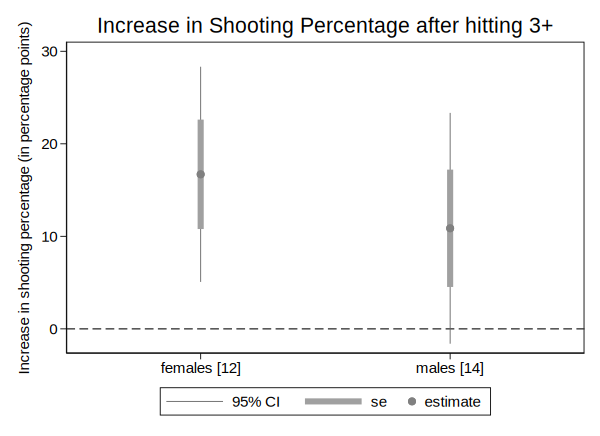


.     global stata_kernel_graph_counter = $stata_kernel_graph_counter + 1
. }            


In [12]:
clear
qui{
set obs 2
gen male=_n==1
label define male 0 "females (12)" 1 "males (14)"
label values male male
gen diff=.
gen ui95=.
gen li95=.
gen ui_se=.
gen li_se=.
save male_v_female.dta, replace

 



qui: ttest_beta, k(3) sim_data(MS_Bias_guys_k3.dta) command("drop if sid < 200")
return list
clear
use male_v_female.dta
replace diff= 100*r(beta) if male==1
replace ui95= 100*r(ui95)   if male==1
replace li95= 100*r(li95)   if male==1
replace ui_se= 100*r(ui_se)   if male==1
replace li_se= 100*r(li_se)   if male==1
save male_v_female.dta, replace


qui: ttest_beta, k(3) sim_data(MS_Bias_gals_k3.dta) command("drop if sid >= 200")
clear
use male_v_female.dta

replace diff= 100*r(beta) if male==0
replace ui95= 100*r(ui95)   if male==0
replace li95= 100*r(li95)   if male==0
replace ui_se= 100*r(ui_se)   if male==0
replace li_se= 100*r(li_se)   if male==0
save male_v_female.dta, replace
}
twoway (rspike ui95 li95 male, lwidth(thin)) (rspike ui_se li_se male, lwidth(vthick)) (scatter diff male, msymbol(circle)), ytitle(Increase in shooting percentage (in percentage points)) yline(0, lpattern(dash)) ylabel(, angle(horizontal)) xtitle("") xscale(range(-.5 1.5)) xlabel(0 "females [12]" 1 "males [14]") title(Increase in Shooting Percentage after hitting 3+) legend(on order(1 "95% CI" 2 "se" 3 "estimate") rows(1)) scheme(s1mono) scale(1)
